In [1]:
import frank_wolfe
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn import preprocessing


# Set data parameters
n_sell = 10000  # number of seller points
n_buy = 5000  # number of buyer test points
n_test = 5000  # number of test points
d = 5000  # dimensionality of features
K = 100 # number of seller points to pick
seed = 0
np.random.seed(seed)

# Generate some random seller data for demonstration
X_sell = np.random.normal(size=(n_sell, d))
X_sell /= np.linalg.norm(X_sell, axis=1, keepdims=True)  # normalize data

beta_true = np.random.exponential(scale=1, size=d)
beta_true *= np.sign(np.random.random(size=d))
y_sell = X_sell @ beta_true + 10*np.random.randn(n_sell)


# Generate some random buyer data for demonstration
all_X_buy = np.random.normal(size=[n_buy, d])
all_X_buy /= np.linalg.norm(all_X_buy, axis=1, keepdims=True)  # normalize data
# X_buy = X_sell[np.random.choice(np.arange(n_sell),K)]
all_true_buy = all_X_buy @ beta_true

# Generate some test data
X_test = np.random.normal(size=[n_test, d])
X_test /= np.linalg.norm(X_test, axis=1, keepdims=True)  # normalize data
# X_test = X_sell[np.random.choice(np.arange(n_sell),K)]
true_test = X_test @ beta_true

In [2]:
X_sell.shape, y_sell.shape, all_X_buy.shape, all_true_buy.shape

((10000, 5000), (10000,), (5000, 5000), (5000,))

In [7]:
# Picking just based on dot product i.e. just based on first gradient.
sims = np.mean((X_sell @ np.linalg.pinv(X_sell.T @ X_sell) @ all_X_buy.T)**2, axis = 1)
# sims = np.mean((X_sell @ all_X_buy.T)**2, axis = 1)
dot_data_indices = np.argsort(sims)[-K:]
print("Selection based on dot product")
dot_results = frank_wolfe.evaluate_indices(X_sell, y_sell, all_X_buy, all_true_buy, X_test, true_test, 0, dot_data_indices)
print('buy', dot_results['buy_error'], '\ttest', dot_results['test_error'])

# Train a linear model from a random subselection of sellers data
num_trials = 20
seller_buy_error = np.zeros(num_trials)
seller_test_error = np.zeros(num_trials)
for i in range(num_trials):
    rand_indices = np.random.choice(n_sell, K, replace=True)
    coeff_hat = frank_wolfe.least_norm_linear_regression(X_sell[rand_indices],
                                                       y_sell[rand_indices])
    seller_buy_error[i] = frank_wolfe.MSE(all_X_buy, all_true_buy, coeff_hat)
    seller_test_error[i] = frank_wolfe.MSE(X_test, true_test, coeff_hat)
print("Random seller selection gives buyer error (mean and std): ", np.mean(seller_buy_error).round(4), "±", np.std(seller_buy_error).round(4) ,"\n")
print("Random seller selection gives test error (mean and std): ", np.mean(seller_test_error).round(4), "±", np.std(seller_test_error).round(4) ,"\n")


# Train a linear model from a random subselection of buyers data
buyer_buy_error = np.zeros(num_trials)
buyer_test_error = np.zeros(num_trials)
for i in range(num_trials):
    rand_indices = np.random.choice(all_X_buy.shape[0], K, replace=True)
    coeff_hat = frank_wolfe.least_norm_linear_regression(all_X_buy[rand_indices],
                                                       all_true_buy[rand_indices])
    buyer_buy_error[i] = frank_wolfe.MSE(all_X_buy, all_true_buy, coeff_hat)
    buyer_test_error[i] = frank_wolfe.MSE(X_test, true_test, coeff_hat)
print("random buyer selection gives buyer error (mean and std): ", np.mean(buyer_buy_error).round(4), "±", np.std(buyer_buy_error).round(4) ,"\n")
print("random buyer selection gives test error (mean and std): ", np.mean(buyer_test_error).round(4), "±", np.std(buyer_test_error).round(4) ,"\n")

Selection based on dot product
buy 4.864090418946182 	test 4.754568296707646
Random seller selection gives buyer error (mean and std):  3.9224 ± 0.324 

Random seller selection gives test error (mean and std):  3.9276 ± 0.3455 

random buyer selection gives buyer error (mean and std):  1.8174 ± 0.0102 

random buyer selection gives test error (mean and std):  1.8612 ± 0.0107 



In [8]:
from sklearn.linear_model import LinearRegression
from opendataval.dataloader import DataFetcher
from opendataval.dataval import DataOob
from opendataval.model import RegressionSkLearnWrapper

fetcher = DataFetcher.from_data_splits(X_sell, y_sell, np.ones_like(X_sell), np.ones_like(y_sell), np.ones_like(X_sell), np.ones_like(y_sell), one_hot=False)
pred_model = RegressionSkLearnWrapper(LinearRegression)
oob = DataOob(random_state=0, num_models=100)
oob.train(fetcher=fetcher, pred_model=pred_model)
oob_indices = np.argsort(oob.data_values)[-K:]

In [11]:
frank_wolfe.evaluate_indices(X_sell, y_sell, all_X_buy, all_true_buy, X_test, true_test, 0, oob_indices)

{'i': '',
 'coord': 0,
 'exp_loss': 135133830051.5914,
 'precision': 0.999999999999988,
 'recall': 0.14104447567870446,
 'buy_error': 3.390026690676763,
 'test_error': 3.37620360870899}

In [135]:
# def least_norm_linear_regression(X, y):
#     """
#     Compute the least norm linear regression solution.

#     Parameters:
#     - X: Input feature matrix (n_samples, n_features)
#     - y: Target values (n_samples,)

#     Returns:
#     - Coefficients of the linear regression model
#     """

#     # Compute the least squares solution using the Moore-Penrose pseudo-inverse
#     coefficients = np.linalg.pinv(X).dot(y)

#     return coefficients


# def MSE(X, y, coeff):
#     """
#     Compute the Mean Squared Error (MSE) for linear regression.

#     Parameters:
#     - X: Input feature matrix (n_samples, n_features)
#     - y: Actual target values (n_samples,)
#     - coeff: Coefficients of the linear regression model (n_features,)

#     Returns:
#     - Mean Squared Error (MSE)
#     """
#     # Compute predicted y values
#     y_pred = X.dot(coeff)

#     # Compute the squared differences between predicted and actual y values
#     squared_errors = (y - y_pred) ** 2

#     # Compute the mean of squared errors to get MSE
#     mse = np.mean(squared_errors)

#     return mse

# def plot_matrix(symmetric_matrix):
#   """
#   Plots the top and bottom eigenvalue as an ellipse to visualize a matrix.

#   Parameters:
#   - symmetric_matrix: A symmetric PSD matrix

#   Returns:

#   """
#   # Find eigenvalues and eigenvectors
#   eigenvalues, _ = np.linalg.eigh(symmetric_matrix)
#   eigenvalues = np.abs(eigenvalues)
#   # Sort eigenvalues in ascending order
#   eigenvalues = np.sort(eigenvalues)

#   # Largest and smallest eigenvalues
#   largest_eigenvalue = eigenvalues[-1]
#   smallest_eigenvalue = eigenvalues[0]

#   # Create an ellipse using the largest and smallest eigenvalues
#   theta = np.linspace(0, 2 * np.pi, 100)
#   a = np.sqrt(largest_eigenvalue)
#   b = np.sqrt(smallest_eigenvalue)
#   x = a * np.cos(theta)
#   y = b * np.sin(theta)

#   # Plot the ellipse
#   plt.figure(figsize=(6, 6))
#   plt.plot(x, y, label='Ellipse', color='b')

#   # Set plot limits, labels, and legend
#   plt.xlim(-a, a)
#   plt.ylim(-b, b)
#   plt.xlabel('X')
#   plt.ylabel('Y')
#   plt.legend()

#   # Show the plot
#   plt.gca().set_aspect('equal', adjustable='box')
#   plt.grid()
#   plt.show()


# def project_onto_subspace(v, W):
#     """
#     Project vector v onto the subspace spanned by the row of W.

#     Args:
#     - v (np.ndarray): The vector(s) to be projected. Shape (d,) or (n, d).
#     - W (np.ndarray): The matrix whose columns span the subspace. Shape (k, d).

#     Returns:
#     - np.ndarray: The projection of v onto the subspace. Shape (d,) or (n, d).
#     """
#     # Compute the projection
#     proj = v @ W.T @ np.linalg.inv(W @ W.T) @ W

#     return proj


# def measure_coverage(X_selected, X_buy):
#     """
#     Measure coverage as precision and recall. Higher is better for both.
#     Precision is a number in [0,1] measuring how much of the selected datapoints are relevant to the buyer.
#     Recall is a number in [0,1] measuring how much of the buyer's data is covered by selected datapoints.

#     Args:
#     - X_selected (np.ndarray): Shape (K, d).
#     - X_buy (np.ndarray): Shape (m, d).

#     Returns:
#     - float, float both in range [0,1]: Precision, Recall
#     """
#     # How much of the selected datapoints are relevant to buy?
#     proj_onto_buy = project_onto_subspace(X_selected, X_buy)
#     precision = np.mean(np.linalg.norm(proj_onto_buy, axis=1))

#     # How much of the buy is covered by selected datapoints?
#     proj_onto_sell = project_onto_subspace(X_buy, X_selected)
#     recall = np.mean(np.linalg.norm(proj_onto_sell, axis=1))

#     return precision, recall


# def evaluate_indices(X_sell, y_sell, X_buy, true_buy, X_test, test_true, data_indices, inverse_covariance = None, i = "", verbose=False):
#     # Train a linear model from the subselected sellers data
#     X_selected = X_sell[data_indices]
#     if inverse_covariance is None:
#       inverse_covariance = np.linalg.pinv(X_selected.T @ X_selected)
#     coeff_hat = least_norm_linear_regression(X_selected,
#                                             y_sell[data_indices])
#     buyer_error = MSE(X_buy, true_buy, coeff_hat)
#     exp_loss = compute_exp_design_loss(X_buy, inverse_covariance)
#     precision, recall = measure_coverage(X_selected, X_buy)
#     test_error = MSE(X_test, true_test, coeff_hat)
#     if verbose:
#         print(i,
#           f"coord: {update_coord}",
#           f"exp_loss: {exp_loss:.6f}",
#           f"precision: {precision:.2f}",
#           f"recall: {recall:.2f}",
#           f"buyer_error: {buyer_error:.6f}",
#           f"test_error: {test_error:.4f}",
#           sep='\t',
#           )
#     return {
#           "exp_loss": exp_loss,
#           "precision": precision,
#           "recall": recall,
#           "buyer_error": buyer_error,
#           "test_error": test_error,
#     }



In [ ]:
# def sherman_morrison_update_inverse(A_inv, u, v):
#     """
#     Update the inverse of a matrix A_inv after a rank-one update (A + uv^T).

#     Parameters:
#     - A_inv: The inverse of the original matrix A (d,d)
#     - u: Column vector u (d,)
#     - v: Column vector v (d,)

#     Returns:
#     - The inverse of (A + uv^T)
#     """

#     # Calculate the denominator term (1 + v^T * A_inv * u)
#     denominator = 1. + v.T @ A_inv @ u

#     # Calculate the update term (A_inv * u * v^T * A_inv)
#     update_term = (A_inv @ u)[:, None] @ (v.T @ A_inv)[None, :]

#     # Update the inverse using the Sherman-Morrison formula
#     updated_inverse = A_inv - (update_term / denominator)

#     return updated_inverse


# def compute_exp_design_loss(X_buy, inverse_covariance):
#     """
#     Compute the experiment design loss.

#     Parameters:
#     - X_buy: Buyer data matrix of shape (n_buy, d)
#     - inverse_covariance: Inverse covariance matrix of shape (d, d)

#     Returns:
#     - loss value
#     """

#     # Compute the matrix product E[x_0^T P x_0]
#     return np.mean((X_buy @ inverse_covariance) * X_buy) * X_buy.shape[-1]

# def compute_neg_gradient(X_sell, X_buy, inverse_covariance):
#     """
#     Compute the negative gradient vector of the exp design loss.

#     Parameters:
#     - X_sell: Sellers data matrix of shape (n_sell, d)
#     - X_buy: Buyer data matrix of shape (n_buy, d)
#     - inverse_covariance: Inverse covariance matrix of shape (d, d)

#     Returns:
#     - Gradient vector of shape (n_sell,)
#     """

#     # Compute the intermediate matrix product  x_i^T P x_0
#     product_matrix = X_sell @ inverse_covariance @ X_buy.T

#     # Calculate the squared norms of rows E(x_i^T P x_0)^2
#     neg_gradient = np.mean(product_matrix ** 2, axis=1)

#     return neg_gradient


# # Define the experiment design loss function
# def opt_step_size(X_sell_data, X_buy, inverse_covariance, old_loss):
#     """
#     Compute the optimal step size to minimize exp design loss along chosen coordinate .

#     Parameters:
#     - X_sell_data: Sellers data being updated (d,)
#     - X_buy: Buyer data matrix of shape (n_buy, d)
#     - inverse_covariance: Inverse covariance matrix of shape (d, d)
#     - old_loss: previous value of loss

#     Returns:
#     - optimal step size (value in [0,1])
#     - new loss
#     """
#     # OPTION I: recopmute loss for different updated inverse matrix.
#     # def new_loss(alpha):
#     #     updated_inv = sherman_morrison_update_inverse(
#     #         inverse_covariance / (1-alpha),
#     #         alpha * X_sell_data,
#     #         X_sell_data,
#     #     )
#     #     return np.mean((X_buy @ updated_inv) * X_buy)

#     # OPTION II: efficient line search by reusing computations
#     a = old_loss
#     # # E(x_0 P x_i)^2
#     prod = (X_sell_data.T @ inverse_covariance) @ X_buy.T
#     b = np.mean(prod ** 2)
#     c = X_sell_data @ inverse_covariance @ X_sell_data

#     # print(a, b, c)
#     # Compute optimal step size
#     loss = lambda x: (1 / (1 - x)) * (a - (x * b) / (1 - x * (1 - c)))
#     result = minimize_scalar(loss, bounds=(0, 0.9))
#     return result.x, result.fun

In [13]:
def scale_cov(X):
    X_scaled = X - X.min()
    return X_scaled / (X.max() - X.min())

In [29]:
from importlib import reload
reload(frank_wolfe)

from collections import defaultdict
weight = defaultdict(int)
sampled_errors = defaultdict(list)
fixed_errors = defaultdict(list)
sampled_losses = defaultdict(list)
fixed_losses = defaultdict(list)

# buyers = (1, 10, 100, 1000)
buyers = (10, 100, 1000)
for n_buy in buyers:
    print(str(n_buy).center(40, '-'))

    X_buy = all_X_buy[:n_buy]
    true_buy = all_true_buy[:n_buy]

    # Initialize coefficients and other hyperparameters
    w = np.ones(n_sell) / n_sell  # initialize seller weights
    n_iterations = 150


    X_sell_tr = np.double(X_sell)
    # OPTIONAL: Preprocess seller points by projecting onto buyer's data
    # X_sell_tr = project_onto_subspace(X_sell, X_buy)


    # inverse_covariance = np.eye(d)  # assume covarince of seller's data is identity
    # OPTIONAL: Compute exact inverse covariance
    inverse_covariance = n_sell * np.linalg.pinv(X_sell_tr.T @ X_sell_tr)

    # scale inverse covariance matrix
    # scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    # inverse_covariance = scale.fit_transform(inverse_covariance)
    # inverse_covariance = scale_cov(inverse_covariance)

    exp_design_loss = frank_wolfe.compute_exp_design_loss(X_buy, inverse_covariance)

    # Frank_wolfe update algorithm
    for i in range(n_iterations):
        # Pick coordinate to update
        neg_gradient = frank_wolfe.compute_neg_gradient(X_sell_tr, X_buy, inverse_covariance)
        update_coord = np.argmax(neg_gradient)  # pick largest grad coordinate

        # OPTION I: Set step size using line search
        alpha, exp_design_loss = frank_wolfe.opt_step_size(X_sell_tr[update_coord],
                                            X_buy,
                                            inverse_covariance,
                                            exp_design_loss)
        # OPTION II: Set a fixed step size
        # alpha = 1 / K
        alpha = 0.1
        # OPTION III: Set time decaying step size
        # alpha = 2 / (3 + i)
        # print(f'{alpha=}')

        # Update w vector
        w *= (1 - alpha)  # shrink w vector in place
        w[update_coord] += alpha  # increase the picked coordinate in magnitude

        # Update the inverse covariance matrix
        # plot_matrix(inverse_covariance)
        inverse_covariance /= (1-alpha)  # update the inverse wrt the w shrinking
        inverse_covariance = frank_wolfe.sherman_morrison_update_inverse(  # update the inverse wrt w_i increasing
            inverse_covariance,
            alpha*X_sell_tr[update_coord, :],
            X_sell_tr[update_coord, :],
        )
        # scale inverse covariance matrix
        inverse_covariance = scale_cov(inverse_covariance)

        # Compute and print error every 10 steps.
        # sample proportional to w
        fixed_data_indices = np.argsort(w)[-K:]
        fixed_results = frank_wolfe.evaluate_indices(X_sell, y_sell, X_buy, true_buy, fixed_data_indices, inverse_covariance)
        
        sampled_data_indices = np.unique(np.random.choice(np.arange(len(w)), K, p=w))
        sampled_results = frank_wolfe.evaluate_indices(X_sell, y_sell, X_buy, true_buy, sampled_data_indices, inverse_covariance)
        
        if i % 20 == 0:
            print(fixed_results)
            print(sampled_results)
        
        fixed_errors[n_buy].append(fixed_results['mse_error'])
        fixed_losses[n_buy].append(fixed_results['exp_loss'])
        sampled_errors[n_buy].append(sampled_results['mse_error'])
        sampled_losses[n_buy].append(sampled_results['exp_loss'])


-------------------10-------------------
{'exp_loss': 0.00018244867736657257, 'precision': 0.04289873612140277, 'recall': 0.13962779487243776, 'mse_error': 2.8170817246103197}
{'exp_loss': 0.00018244867736657257, 'precision': 0.04410218597952286, 'recall': 0.13598707441622607, 'mse_error': 4.293797772149814}
{'exp_loss': 0.00018245691207818005, 'precision': 0.04280805327552261, 'recall': 0.13958794329069285, 'mse_error': 4.308436983136459}
{'exp_loss': 0.00018245691207818005, 'precision': 0.0456651141511682, 'recall': 0.0631306343761662, 'mse_error': 2.919868426491302}
{'exp_loss': 0.00018240446724553848, 'precision': 0.04325894249109074, 'recall': 0.1404559758410723, 'mse_error': 4.574283710906933}
{'exp_loss': 0.00018240446724553848, 'precision': 0.04725412031812514, 'recall': 0.04894975692316989, 'mse_error': 3.0572371797177973}
{'exp_loss': 0.00018224710805264763, 'precision': 0.043258942491090725, 'recall': 0.1404559758410723, 'mse_error': 4.574283710906938}
{'exp_loss': 0.0001822

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


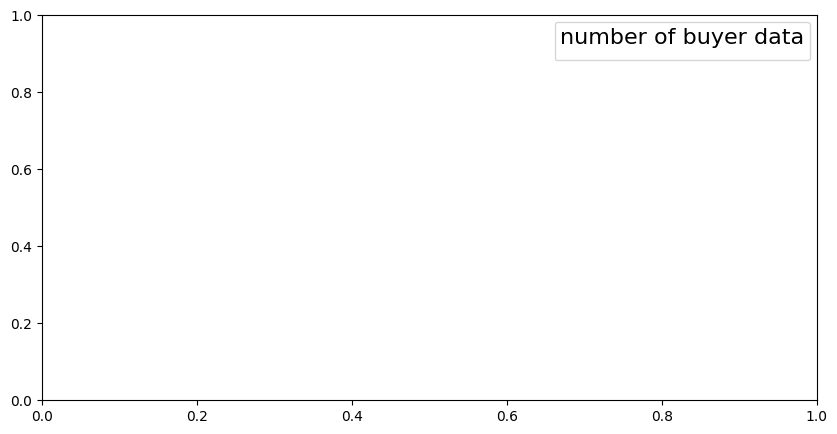

In [23]:
import matplotlib
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, 4).astype(int)]
plt.figure(figsize=(10, 5))
# for i, (k, v) in enumerate(buy_errors.items()):
for i, (k, v) in enumerate(sample_errors.items()):
# for i, (k, v) in enumerate(test_errors.items()):
    if i > 5:
        continue
    plt.plot(v, label=f'{k}', c=colors[i], lw=4)
    # plt.axhline(np.mean(v), label=f'{k} (average)', ls='--', c=colors[i])
# plt.yscale('log')
plt.legend(ncols=2, title='number of buyer data', title_fontsize=16)

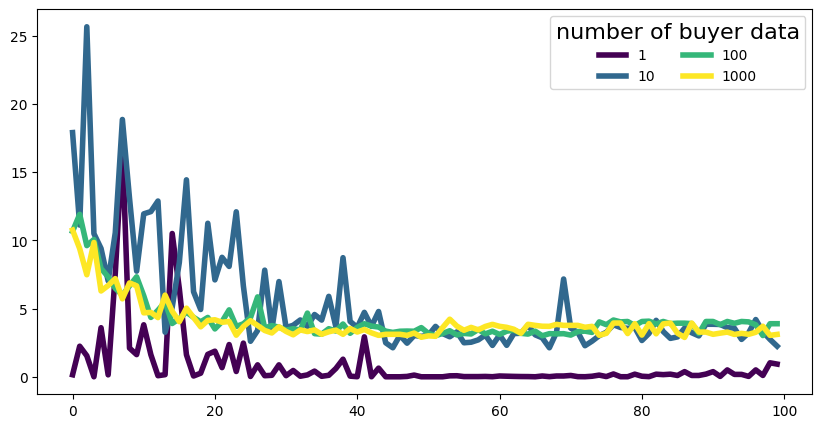

In [120]:
import matplotlib
cmap = matplotlib.colormaps['viridis'].colors
colors = np.array(cmap)[np.linspace(0, 255, 4).astype(int)]
plt.figure(figsize=(10, 5))
# for i, (k, v) in enumerate(buy_errors.items()):
for i, (k, v) in enumerate(sample_errors.items()):
# for i, (k, v) in enumerate(test_errors.items()):
    if i > 5:
        continue
    plt.plot(v, label=f'{k}', c=colors[i], lw=4)
    # plt.axhline(np.mean(v), label=f'{k} (average)', ls='--', c=colors[i])
# plt.yscale('log')
plt.legend(ncols=2, title='number of buyer data', title_fontsize=16)

In [126]:
our_data_indices.shape

(13,)

In [122]:
# Pick out the K largest coordinates
# our_data_indices = np.argsort(w)[-K:]
our_data_indices = np.unique(np.random.choice(np.arange(len(w)), K, p=w))
print("Our selection")
our_results = evaluate_indices(X_sell, y_sell, X_buy, true_buy, X_test, true_test, our_data_indices)
print('buyer', our_results['buyer_error'], 'test', our_results['test_error'])

# Picking just based on dot product i.e. just based on first gradient.
sims = np.mean((X_sell @ X_buy.T)**2, axis = 1)
sims = np.mean((X_sell @ np.linalg.inv(X_sell.T @ X_sell) @ X_buy.T)**2, axis = 1)
dot_data_indices = np.argsort(sims)[-K:]
print("Selection based on dot product")
dot_results = evaluate_indices(X_sell, y_sell, X_buy, true_buy, X_test, true_test, dot_data_indices)
print('buyer', dot_results['buyer_error'], 'test', dot_results['test_error'])

# Train a linear model from a random subselection of sellers data
num_trials = 10
buy_rand_error = np.zeros(num_trials)
test_rand_error = np.zeros(num_trials)
for i in range(num_trials):
  rand_indices = np.random.choice(n_sell, K, replace=False)
  coeff_hat = least_norm_linear_regression(X_sell[rand_indices],
                                          y_sell[rand_indices])
  buy_rand_error[i] = MSE(X_buy, true_buy, coeff_hat)
  test_rand_error[i] = MSE(X_test, true_test, coeff_hat)
print("Random selection gives buy error (mean and std): ", np.mean(buy_rand_error), "±", np.std(buy_rand_error) ,"\n")
print("Random selection gives test error (mean and std): ", np.mean(test_rand_error), "±", np.std(test_rand_error) ,"\n")




Our selection
buyer 3.2745634484485047 test 3.513435575621313
Selection based on dot product
buyer 13.8006123582777 test 13.679396844839813
Random selection gives buy error (mean and std):  12.691441769483456 ± 1.8036584858336424 

Random selection gives test error (mean and std):  12.616630254490758 ± 1.6551631243432832 



In [128]:
from sklearn.linear_model import LinearRegression
from opendataval.dataloader import DataFetcher
from opendataval.dataval import DataOob
from opendataval.model import RegressionSkLearnWrapper

fetcher = DataFetcher.from_data_splits(X_sell, y_sell, np.ones_like(X_sell), np.ones_like(y_sell), np.ones_like(X_sell), np.ones_like(y_sell), one_hot=False)
pred_model = RegressionSkLearnWrapper(LinearRegression)
oob = DataOob(random_state=0, num_models=100)
oob.train(fetcher=fetcher, pred_model=pred_model)
oob_indices = np.argsort(oob.data_values)[-K:]


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


In [130]:
evaluate_indices(X_sell, y_sell, X_buy, true_buy, X_test, true_test, oob_indices)

{'exp_loss': 0.11154143006471304,
 'precision': 1.000000000000069,
 'recall': 0.3163720111618474,
 'buyer_error': 2.796645064571753,
 'test_error': 2.762489339679453}

In [11]:
import torch
from pathlib import Path
from importlib import reload
import selection
reload(selection)
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

use_iid = False

# Set data parameters
n_sell = 100000  # number of seller points
n_buy = 50  # number of buyer test points
d = 100  # dimensionality of features
K = n_buy  # number of seller points to pick
seed = 0
np.random.seed(seed)

x = np.double(np.array(torch.load("../data/bone-age-resnet50-features.pt")))
y = np.array(torch.load("../data/bone-age-labels.pt"))

if use_iid:
    X_sell, X_buy, y_sell, true_buy  = train_test_split(
        x,
        y,
        test_size=0.3,
        random_state=seed,
    )

else:
    KM = KMeans(n_clusters=2, init="k-means++").fit(x)
    cluster_indices = KM.labels_
    cluster_1 = cluster_indices == 0
    cluster_2 = cluster_indices == 1
    
    x_train, x_test, y_train, y_test = train_test_split(
        x[cluster_1],
        y[cluster_1],
        test_size=0.3,
        random_state=seed,
    )
    
    X_sell = np.concatenate([x[cluster_2], x_train])
    y_sell = np.concatenate([y[cluster_2], y_train])
    
    X_buy = x_test
    true_buy = y_test

X_buy = X_buy = X_buy[:n_buy]
true_buy = true_buy[:n_buy]
n_sell = X_sell.shape[0]
print(X_sell.shape, X_buy.shape)


/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(10880, 1000) (50, 1000)


In [12]:
# Initialize coefficients and other hyperparameters
w = np.ones(n_sell) / n_sell  # initialize seller weights
n_iterations = 10*K

X_sell_tr = X_sell.copy()
# OPTIONAL: Preprocess seller points by projecting onto buyer's data
# X_sell_tr = project_onto_subspace(X_sell, X_buy)


# inverse_covariance = np.eye(d)  # assume covarince of seller's data is identity
# OPTIONAL: Compute exact inverse covariance
inverse_covariance = n_sell * np.linalg.pinv(np.double(X_sell_tr).T @ np.double(X_sell_tr))


exp_design_loss = selection.compute_exp_design_loss(X_buy, inverse_covariance)



# Frank_wolfe update algorithm
for i in range(10*K):
# for i in range(1000*K):
# for i in range(K):
    # Pick coordinate to update
    neg_gradient = selection.compute_neg_gradient(X_sell_tr, X_buy, inverse_covariance)
    update_coord = np.argmax(neg_gradient)  # pick largest grad coordinate

    # OPTION I: Set step size using line search
    alpha, exp_design_loss = selection.opt_step_size(X_sell_tr[update_coord],
                                                     X_buy,
                                                     inverse_covariance,
                                                     exp_design_loss)
    # OPTION II: Set a fixed step size
    # alpha = 1. / K
    # OPTION III: Set time decaying step size
    # alpha = 2 / (3 + i)
    # alpha = 0.01

    # Update w vector
    w *= (1 - alpha)  # shrink w vector in place
    w[update_coord] += alpha  # increase the picked coordinate in magnitude

    # Update the inverse covariance matrix
    # plot_matrix(inverse_covariance)
    inverse_covariance /= (1-alpha)  # update the inverse wrt the w shrinking
    inverse_covariance = selection.sherman_morrison_update_inverse(  # update the inverse wrt w_i increasing
        inverse_covariance,
        alpha*X_sell_tr[update_coord, :],
        X_sell_tr[update_coord, :],
    )

    # Compute and print error every 10 steps.
    # if i % 100 == 0:
    if i % 1 == 0:
        data_indices = np.argsort(w)[-K:]
        selection.evaluate_indices(X_sell, y_sell, X_buy, true_buy, update_coord, data_indices, inverse_covariance, i)
        print(inverse_covariance.sum(), inverse_covariance.min(), inverse_covariance.max())
    

/tmp/ipykernel_650750/704799895.py:12: RuntimeWarning: invalid value encountered in matmul
  inverse_covariance = n_sell * np.linalg.pinv(np.double(X_sell_tr).T @ np.double(X_sell_tr))


0   coord : 8580.0000   exp_loss: 1073.2933   precision : 23.1074   recall : 23.8494   error : 1162.0072
0.06638667457809788 -8665.547415558694 26258.28912612175
1   coord : 9978.0000   exp_loss: 1073.0793   precision : 23.1311   recall : 23.8505   error : 1130.4431
0.06639760352936719 -8668.254737379964 26251.62339707172
2   coord : 8170.0000   exp_loss: 1072.8977   precision : 23.1318   recall : 23.8519   error : 1062.6049
0.06638614051735203 -8670.593331737402 26252.175758566085
3   coord : 9327.0000   exp_loss: 1072.7107   precision : 23.1229   recall : 23.8521   error : 1166.0345
0.06640835602320294 -8677.585167394305 26227.402986449688
4   coord : 1612.0000   exp_loss: 1072.5138   precision : 23.1056   recall : 23.8513   error : 1196.4400
0.0664037012920744 -8680.165098104728 26224.2909129805
5   coord : 10205.0000   exp_loss: 1072.3617   precision : 23.1232   recall : 23.8528   error : 1068.3016
0.06640069817967742 -8680.777399638786 26233.360784236254
6   coord : 6875.0000   ex

In [13]:
# Pick out the K largest coordinates
our_data_indices = np.argsort(w)[-K:]
print("Our selection")
selection.evaluate_indices(X_sell, y_sell, X_buy, true_buy, update_coord, our_data_indices)
print()

# Picking just based on dot product i.e. just based on first gradient.
sims = np.mean((X_sell @ X_buy.T)**2, axis = 1)
dot_data_indices = np.argsort(sims)[-K:]
print("Selection based on dot product")
selection.evaluate_indices(X_sell, y_sell, X_buy, true_buy, update_coord, dot_data_indices)
print()

# Train a linear model from a random subselection of sellers data
num_trials = d
rand_error = np.zeros(num_trials)
for i in range(num_trials):
  rand_indices = np.random.choice(n_sell, K, replace=False)
  coeff_hat = selection.least_norm_linear_regression(X_sell[rand_indices],
                                          y_sell[rand_indices])
  rand_error[i] = selection.MSE(X_buy, true_buy, coeff_hat)
print("Random seller selection gives error (mean and std): ", np.mean(rand_error), "±", np.std(rand_error) ,"\n")


# Train a linear model from a random subselection of buyers data
num_trials = d
rand_error = np.zeros(num_trials)
for i in range(num_trials):
  rand_indices = np.random.choice(n_buy, K, replace=False)
  coeff_hat = selection.least_norm_linear_regression(X_buy[rand_indices],
                                        true_buy[rand_indices])
  rand_error[i] = selection.MSE(X_buy, true_buy, coeff_hat)
print("Random buyer selection gives error (mean and std): ", np.mean(rand_error), "±", np.std(rand_error) ,"\n")


Our selection
   coord : 10022.0000   exp_loss: 0.4248   precision : 23.3953   recall : 23.8579   error : 1598.9444

Selection based on dot product
   coord : 10022.0000   exp_loss: 0.5884   precision : 24.7544   recall : 23.8426   error : 1137.8476

Random seller selection gives error (mean and std):  1499.9808542223684 ± 283.8335886391338 

Random buyer selection gives error (mean and std):  3.7896473990033934e-25 ± 3.9728557236625573e-25 



In [9]:
from opendataval.dataloader import DataFetcher
from opendataval.dataval import DataOob
from opendataval.model import RegressionSkLearnWrapper

fetcher = DataFetcher.from_data_splits(X_sell, y_sell, X_buy, true_buy, X_buy, true_buy, one_hot=False)
pred_model = RegressionSkLearnWrapper(LinearRegression)
oob = DataOob(random_state=0, num_models=10)
oob.train(fetcher=fetcher, pred_model=pred_model)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]


DataOob(random_state=0, num_models=10)

In [10]:
oob_indices = np.argsort(oob.data_values)[-K:]
selection.evaluate_indices(X_sell, y_sell, X_buy, true_buy, update_coord, oob_indices)

   coord : 2027.0000   exp_loss: 272114870.8348   precision : 23.4660   recall : 24.0105   error : 2510.4195
